Importamos las librerías que vamos a necesitar

In [1]:
import numpy as np
import ctypes
import time
import statistics
import matplotlib.pyplot as plt

In [2]:
arr = np.random.rand(7)

Creamos nuestra función de varianza en C

In [3]:
%%file cVarianza.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

double cVarianza(double *arr,int N){
    double mu = 0;
    for (int i = 0; i < N; i++)
    {
        mu += arr[i];
    }
    mu = N != 0 ? mu/(double)N : 0;
    //return N != 0 ? mu/(double)N : 0;

    double sum = 0;

    for (int i = 0; i < N; i++)
    {
        sum += pow(arr[i]-mu,2);
    }
    
    return N != 0 ? sum/(double)N : 0;
}

Overwriting cVarianza.c


Linkeamos el ejecutable de C como una librería compartida para usar en python

In [4]:
! gcc -c -Wall -Werror -fpic cVarianza.c
! gcc -shared cVarianza.o -o _cVarianza.so

Definimos la función con ctypes en python

In [5]:
def ctypes_cVarianza():
    # ruta de la shared library
    lib = ctypes.CDLL('./_cVarianza.so')
    
    # tipo de los argumentos
    lib.cVarianza.argtypes = [
        np.ctypeslib.ndpointer(dtype = np.float64),
        ctypes.c_int
    ]

    # definimos el tipo de salida de la función
    lib.cVarianza.restype = ctypes.c_double

    # se devuelve la función configurada
    return lib.cVarianza

In [6]:
cVarianza = ctypes_cVarianza()

Probamos nuestra función

In [7]:
print("Arreglo:",end = " ")
print(arr)
var = cVarianza(arr, arr.size)
print("Varianza:",end = " ")
print(var)

Arreglo: [0.74671483 0.64799793 0.13995442 0.79571116 0.31613709 0.79493711
 0.18363634]
Varianza: 0.07407051566887539


Implementamos la misma función en lenguaje ensamblador

In [8]:
%%file asmVarianza.asm
    global asmVarianza
    section .text
asmVarianza:
    xorpd xmm0,xmm0
    xorpd xmm1,xmm1
    xorpd xmm6,xmm6
    xorpd xmm7,xmm7
    mov r8,0
    mov rcx, rsi
    cvtsi2sd xmm6, rsi
    cmp rsi,0
    je done
mu:
    movsd xmm0, [rdi + r8]
    addsd xmm1,xmm0
    add r8,8
    loop mu
        
    divsd xmm1,xmm6 ;Guardamos en xmm1 el mu
    
    mov rcx, rsi
    mov r8,0
    
varianza:
    movsd xmm0, [rdi + r8]
    subsd xmm0,xmm1
    mulsd xmm0,xmm0
    addsd xmm7,xmm0
    add r8,8
    loop varianza

    divsd xmm7,xmm6
    movsd xmm0, xmm7
done:
    ret 

Overwriting asmVarianza.asm


In [9]:
%%file asmVarianza.c
extern double asmVarianza(double *arr, int size);

Overwriting asmVarianza.c


In [10]:
! nasm -f elf64 -g asmVarianza.asm -o asmVarianza.o
! gcc -shared asmVarianza.o asmVarianzaC.c -o asmVarianza.so

Definimos la función con ctypes en python

In [11]:
def ctypes_asmVarianza():
    # ruta de la shared library
    lib = ctypes.CDLL('./asmVarianza.so')
    
    # tipo de los argumentos
    lib.asmVarianza.argtypes = [
        np.ctypeslib.ndpointer(dtype = np.float64),
        ctypes.c_int
    ]

    # definimos el tipo de salida de la función
    lib.asmVarianza.restype = ctypes.c_double

    # se devuelve la función configurada
    return lib.asmVarianza

In [12]:
asmVarianza = ctypes_asmVarianza()

Probamos nuestra función

In [13]:
print("Arreglo:",end = " ")
print(arr)
var = asmVarianza(arr, arr.size)
print("Varianza:",end = " ")
print(var)

Arreglo: [0.74671483 0.64799793 0.13995442 0.79571116 0.31613709 0.79493711
 0.18363634]
Varianza: 0.07407051566887539


# Comparación de tiempos de ejecución

In [14]:
def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [15]:
# size of arrays
sizes = 2**np.arange(11,18)

# tiempo en C
time_c = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo con ruido en C
time_c_noise = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo en ASM
time_asm = np.zeros((len(sizes),1),dtype = np.float64)

# tiempo con ruido en ASM
time_asm_noise = np.zeros((len(sizes),1),dtype = np.float64)

In [16]:
veces = 100
tam = sizes[0]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = np.random.rand(tam,1).astype(np.float64)
    yp = np.random.rand(tam,1).astype(np.float64)
    
    # tiempo C
    t = time.time()
    cVarianza(xp,xp.size)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    asmVarianza(xp,xp.size)
    tasmp.append(time.time() - t)

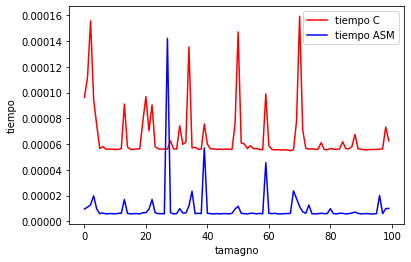

In [17]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()